# Банки — Анализ оттока клиентов

### Задача**:**

Проанализируйте клиентов регионального банка и выделите портрет клиентов, которые склонны уходить из банка.

- Проведите исследовательский анализ данных,
- Выделите портреты клиентов, которые склонны уходить из банка,
- Сформулируйте и проверьте статистические гипотезы.
    
    *Проверьте гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.*
    
    *Сформулируйте и проверьте статистическую гипотезу относительно представленных данных*
    

### Описание датасетов

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.



МАТЕРИАЛЫ:

* [Дашборд](https://public.tableau.com/views/_16593441117900/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link)

* [Презентация](https://disk.yandex.ru/d/CgKFqSm_Dd6bVg)

# Подготовка к исследованию

## Загрузка библиотек и файла 

In [47]:
import pandas as pd
from IPython.display import display
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
!pip install plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
warnings.filterwarnings('ignore') 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

try:
    metpr = pd.read_csv('/datasets/bank_dataset.csv')
except:
    metpr = pd.read_csv('/Users/polinazhuravleva/Downloads/bank_dataset.csv')

display(metpr.head())
metpr.info()

userid  score       City Gender  Age  Objects    Balance  Products  \
0  15677338    619  Ярославль      Ж   42        2        NaN         1   
1  15690047    608    Рыбинск      Ж   41        1  83,807.86         1   
2  15662040    502  Ярославль      Ж   42        8 159,660.80         3   
3  15744090    699  Ярославль      Ж   39        1        NaN         2   
4  15780624    850    Рыбинск      Ж   43        2 125,510.82         1   

   CreditCard  Loyalty  estimated_salary  Churn  
0           1        1        101,348.88      1  
1           0        1        112,542.58      0  
2           1        0        113,931.57      1  
3           0        0         93,826.63      0  
4           1        1         79,084.10      0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


В столбце "Balance" заметно большое количество пропусков, пока не понятно, откуда они могли взяться, проверим далее.

## Подготовка данных к анализу

Для дальнейшего анализа приведем приведем в порядок данные, проведем проверку на дубликаты, проработаем пропуски.

In [48]:
# Приводим названия столбцов к нижнему регистру

metpr.columns = metpr.columns.str.lower()

# Проверим уникальность данных в столбцe, посмотрим, есть ли опечатки
display(metpr['city'].unique())

array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object)

In [49]:
# Проверим уникальность данных по ИД пользователей
metpr['userid'].value_counts().sum()

10000

Из 10000 строк в датасете 10000 уникальных ИД.

In [50]:
# Типы данных 
metpr['creditcard'] = metpr['creditcard'].astype('int8')
metpr['loyalty'] = metpr['loyalty'].astype('int8')
metpr['churn'] = metpr['churn'].astype('int8')

In [51]:
# Проверка на дубликаты
metpr.duplicated().sum()

0

Ранее мы отметили большое количетсво пропусков в столбце "balance", необходимо понять, в связи с чем это могло произойти.

In [52]:
# Рассмотрим процент пропусков по столбцам
pd.DataFrame(round((metpr.isna().mean() * 100), 2)).style.background_gradient()

In [53]:
metpr['balance'].isna().sum()

3617

In [54]:
metpr['balance'].describe()

count     6,383.00
mean    119,827.49
std      30,095.06
min       3,768.69
25%     100,181.98
50%     119,839.69
75%     139,512.29
max     250,898.09
Name: balance, dtype: float64

У нас в столбце имеется 3617 пропущенных значений, что является 36,17% от общего количества строк. Это достаточно большое количество, если удалить строки - исследование пройдет некорректно. 


Данное количетсво пропусков может быть обусловлено технической ошибкой, но можно предположить, что не каждый клиент в банке имеет депозитные счета, некоторые пользуются исключительно кредитными продуктами, поэтому у нас есть основание полагать, что пропущенные значения это фактически нули, ведь никакого баланса у этих клиентов нет.


Мы видим (метод describe), что в остальных значениях вообще нет нулей, то есть минимальное в столбце не равно нулю. В таком случае можем предположить, что все-таки могла быть и ошибка при выгрузке данных, которая перевела все нули в пропущенные значения.




In [55]:
metpr['balance'] = metpr['balance'].fillna(0)
# Проведем проверку
metpr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products          10000 non-null  int64  
 8   creditcard        10000 non-null  int8   
 9   loyalty           10000 non-null  int8   
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int8   
dtypes: float64(2), int64(5), int8(3), object(2)
memory usage: 732.5+ KB


In [56]:
#рассмотрим попдробнее строки с 0 (ранее с пустым) балансом
balance_nan = metpr[metpr['balance'] == 0]
balance_nan.head()

userid  score       city gender  age  objects  balance  products  \
0   15677338    619  Ярославль      Ж   42        2     0.00         1   
3   15744090    699  Ярославль      Ж   39        1     0.00         2   
6   15635267    822  Ярославль      М   50        7     0.00         2   
11  15779909    497    Рыбинск      М   24        3     0.00         2   
12  15675000    476  Ярославль      Ж   34       10     0.00         2   

    creditcard  loyalty  estimated_salary  churn  
0            1        1        101,348.88      1  
3            0        0         93,826.63      0  
6            1        1         10,062.80      0  
11           1        0         76,390.01      0  
12           1        0         26,260.98      0

In [57]:
balance_nan['churn'].value_counts()

0    3117
1     500
Name: churn, dtype: int64

Большинство людей, у которых был не определен баланс остались клиентами банка, не попадая в отток. в оттоке всего 500 строк

In [58]:
balance_nan['churn'].value_counts()
balance_nan['city'].value_counts()

Ярославль    2418
Рыбинск      1199
Name: city, dtype: int64

Пропуски встречаются не во всех городах.
в Ростове Великом они отсутствуют полностью.

Рассмотрим наличие кредитной карты

In [59]:
balance_nan['creditcard'].value_counts()

1    2592
0    1025
Name: creditcard, dtype: int64

Около 60% имеют кредитную карту. В целом можно предположить, что действительно система в случае отсутствия у клиента дебетовой карты дает такой сбой и это происходит не во всех городах. 

Данный вопрос необходимо вынести на обсуждение, для искоренения проблемы. На данном этапе считаю возможным оставить 0 вместо пропусков, чтобы не зачищать датасет на большое количество строк.

In [60]:
print('Минимальный балл кредитного скоринга:', metpr['score'].min())
print('Максимальный балл кредитного скоринга:', metpr['score'].max())

Минимальный балл кредитного скоринга: 350
Максимальный балл кредитного скоринга: 850


В данном случае используется система скоринга 300-850. Так же бывают другие вариации баллов, однако в любой системе клиенту для одобрения кредита необходимо иметь не менее 600 баллов.

In [61]:
print('Минимальный возраст клиента:', metpr['age'].min())
print('Максимальный возраст клиента:', metpr['age'].max())

Минимальный возраст клиента: 18
Максимальный возраст клиента: 92


Все клиенты в данной выборке - совершеннолетние,неадекватных цифр нет. Проблем с данными нет.

In [62]:
print('Минимальный зароботная плата клиента:', metpr['estimated_salary'].min())
print('Максимальный зароботная плата клиента:', metpr['estimated_salary'].max())

Минимальный зароботная плата клиента: 11.58
Максимальный зароботная плата клиента: 199992.48


Минимальная заработная плата выглядит слишком низкой. Mинимальная заработная плата в России составляет около 12 тыс.руб., однако, могут быть ситуации (инвалиды, домохозяйки и т.п.) Возможно, человек предоставляет изредка какиой-то вид услуг, варианты могут быть разные. Так же возможен вариант, что данные не были предоставлены и значения были получены при расчетах специальной моделью. Посмотрим на данные в нашей выборке, где зп ниже минимальной по стране.

In [63]:
bank_salary = metpr[metpr['estimated_salary'] < 12792]
bank_salary.sample(10)

userid  score            city gender  age  objects    balance  \
4537  15820172    710         Рыбинск      Ж   31        5       0.00   
5629  15644239    578         Рыбинск      М   28        4       0.00   
3300  15844640    677  Ростов Великий      М   28        0 143,988.00   
8028  15817860    763         Рыбинск      М   37        8       0.00   
5925  15826213    706  Ростов Великий      Ж   39        8 112,889.91   
4771  15759355    580  Ростов Великий      Ж   36        3  74,974.89   
2630  15643615    554  Ростов Великий      Ж   36        3 157,780.93   
2312  15766959    545       Ярославль      Ж   55        5       0.00   
6852  15781451    600       Ярославль      Ж   37        4       0.00   
7044  15781223    678       Ярославль      М   26        3       0.00   

      products  creditcard  loyalty  estimated_salary  churn  
4537         2           1        0          9,561.73      0  
5629         2           0        0          6,947.09      0  
3300         2           1        0          8,755.69      1  
8028         2           1        1            933.38      0  
5925         1           0        1          6,723.66      0  
4771         1           1        1         12,099.67      0  
2630         2           1        0          6,089.13      0  
2312         1           0        0         10,034.77      1  
6852         3           1        0          7,312.25      1  
7044         2           1        0          4,989.33      0

Интересно, что у людей, с такой низкой зп на счетах лежит более 50 000 руб. и есть объекты в собственности.

In [64]:
bank_salary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 6 to 9987
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            640 non-null    int64  
 1   score             640 non-null    int64  
 2   city              640 non-null    object 
 3   gender            640 non-null    object 
 4   age               640 non-null    int64  
 5   objects           640 non-null    int64  
 6   balance           640 non-null    float64
 7   products          640 non-null    int64  
 8   creditcard        640 non-null    int8   
 9   loyalty           640 non-null    int8   
 10  estimated_salary  640 non-null    float64
 11  churn             640 non-null    int8   
dtypes: float64(2), int64(5), int8(3), object(2)
memory usage: 51.9+ KB


В данной выборке 640 строк с клиентами, чья заработная плата меньше минимальной по стране.

In [65]:
bank_salary['churn'].value_counts()

0    517
1    123
Name: churn, dtype: int64

Из выборки по ЗП ниже порога, в отток ушло 123 клиента

In [66]:
#Рассмотрим клиентов, у которых ЗП менее 300 руб
bank_salary[bank_salary['estimated_salary'] < 300]

userid  score            city gender  age  objects    balance  \
1451  15726934    551       Ярославль      Ж   38       10       0.00   
1462  15608947    616  Ростов Великий      Ж   41        1 103,560.57   
2362  15833789    709  Ростов Великий      М   45        4 122,917.71   
2498  15691471    718       Ярославль      М   37        8       0.00   
3446  15807390    649       Ярославль      М   37        9  87,374.88   
4774  15683157    811       Ярославль      Ж   35        7       0.00   
4989  15645587    629       Ярославль      М   40        9       0.00   
5548  15682398    710       Ярославль      М   38        2       0.00   
7565  15666105    708       Ярославль      М   52       10 105,355.81   
8502  15617594    530       Ярославль      М   37        8       0.00   
8722  15761403    621       Ярославль      М   35        7  87,619.29   
9010  15829199    645  Ростов Великий      Ж   59        8 121,669.93   
9647  15722429    625       Ярославль      М   31        5       0.00   

      products  creditcard  loyalty  estimated_salary  churn  
1451         2           1        1            216.27      0  
1462         1           1        0            236.45      1  
2362         1           1        1             11.58      1  
2498         2           1        1            142.81      0  
3446         2           1        1            247.36      0  
4774         1           1        1            178.19      0  
4989         1           1        0            106.67      0  
5548         2           1        0             96.27      0  
7565         1           1        0            123.07      1  
8502         2           1        1            287.99      0  
8722         1           1        0            143.34      0  
9010         2           0        0             91.75      1  
9647         2           0        1             90.07      0

В целом в масштабе данной выборки 640 строк это незначительно, но стоит обратить внимание на эту аномалию и изучить вопрос, уточнить у коллег, возможно, это расчетные цифры.

## Вывод по разделу

Мы просмотрели данные и устранили недочеты:
- привели названия столбцов к «змеиному регистру»;
- выяснили, что дубликаты отсутсвуют;
- убедились в уникальности значений в соответствующих столбцах;
- выдвинули возможные причины появления пропущенных значений и приняли решение заполнить их нулями.

Данные готовы для дальнейшего анализа

# Исследовательский анализ данных

## Средние значения и стандартные отклонения

Рассмотрим на числовые показатели данных, исклуючая столбец "userid", так как это простые идентификаторы пользователей.

In [67]:
pd.set_option('display.float_format', '{:,.2f}'.format)
metpr.loc[:, metpr.columns != 'userid'].describe().T

count       mean       std    min       25%        50%  \
score            10,000.00     650.53     96.65 350.00    584.00     652.00   
age              10,000.00      38.92     10.49  18.00     32.00      37.00   
objects          10,000.00       5.01      2.89   0.00      3.00       5.00   
balance          10,000.00  76,485.89 62,397.41   0.00      0.00  97,198.54   
products         10,000.00       1.53      0.58   1.00      1.00       1.00   
creditcard       10,000.00       0.71      0.46   0.00      0.00       1.00   
loyalty          10,000.00       0.52      0.50   0.00      0.00       1.00   
estimated_salary 10,000.00 100,090.24 57,510.49  11.58 51,002.11 100,193.91   
churn            10,000.00       0.20      0.40   0.00      0.00       0.00   

                        75%        max  
score                718.00     850.00  
age                   44.00      92.00  
objects                7.00      10.00  
balance          127,644.24 250,898.09  
products               2.00       4.00  
creditcard             1.00       1.00  
loyalty                1.00       1.00  
estimated_salary 149,388.25 199,992.48  
churn                  0.00       1.00

Выводы: 

- score: максимальный скоринговый балл равен 850, а минимальный 350, медиана и среднее примерно равны (650)
- age: возраст клиентов от 18 до 92 лет, средний возраст - 39 лет, медиана - 37 лет
- objects: у клиентов количество объектов недвижимости варьируется от 0 до 10, медиана и среднее - 5
- balance: на балансе максимум почти 251 000 у. е., минимум - 0 у. е. Медиана в районе 97 000 у. е., а среднее чуть больше 76 000 у. е.
- products: клиенты пользуются от 1 до 4 продуктов, в среднем у клиентов по 1-2 продукта
- creditcard: 71% клиентов используют кредитную карту
- loyalty: примерно половина клиентов являются активными клиентами
- estimated_salary: максимальная заработная плата почти 200 000 у. е., а минимальная почти 12 у. е. Медиана в районе 100 000 у. е., как и среднее значение
- churn: отток составляет 20%


Остались столбцы с типом данных object, их предлагаю рассмотреть отдельно:

In [68]:
metpr['city'].value_counts()

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

В датасете присутсвует информация по трем городам: Ярославль, Ростов Великий, Рыбинск. Клиенты из Ярославля преобадают.

In [69]:
metpr['gender'].value_counts()

М    5457
Ж    4543
Name: gender, dtype: int64

Мужчин больше, чем женщин в предоставленной информации, но разница не большая.

Рассмотрим более подробно средние значения показателей в разрезе групп по количеству, используемых продуктов:

In [70]:
# используем describe() для вывода среднего по группам количества продуктов
metpr.drop(['userid'], axis=1).groupby('products').describe().T.reset_index().query('level_1 == "mean"')\
.set_index('level_0').drop(['level_1'], axis = 1)

products                 1          2          3          4
level_0                                                    
score               649.12     652.19     648.11     653.58
age                  39.67      37.75      43.20      45.68
objects               4.97       5.05       5.00       5.30
balance          98,551.87  51,879.15  75,458.33  93,733.14
creditcard            0.70       0.71       0.71       0.68
loyalty               0.50       0.53       0.42       0.48
estimated_salary 99,487.26 100,452.01 104,318.13 104,763.72
churn                 0.28       0.08       0.83       1.00

Из полученной таблицы видно, что:
- Клиенты, которые пользуются 1-2 продуктами банка являются представителями обоих полов в примерно равных долях (с небольшим перевесом в сторону мужчин), в возрасте моложе 40 лет, заработком около 100 тыс. рублей, в половине своей активно используют банковские продукты 
- Клиенты из групп с тремя и четырьмя продуктами в большинстве женщины старше 40 лет, с заработной платой чуть выше 100 тыс. рублей, и что характерно, большинство расторгают свои отношения с банком (особенно те, у кого четыре продукта - показатель оттока 100 %).

## Вывод по разделу

Мы изучили числовое описание данных. В них не заметно каких-либо сильных выбросов или отклонений, все выглядит реально и уместно. Модель скоринга, как правило, имеет максимальный порог в 1 000 баллов, а низкие показатели могут быть связаны с плохой кредитной историей. Возраст не выбивается, цифры реальные. В остальном показатели тоже адекватные.

## Средние значения тех, кто ушел в отток и тех, кто остался клиентом банка

Явных и больших аномальных выбросов в выборке не имеется, поэтому предлагаю провести анализ средних значений данных о клиентах по признаку оттока:

In [71]:
metpr.groupby('churn').agg('mean').round(2).T

churn                        0             1
userid           15,733,903.88 15,732,787.96
score                   651.85        645.35
age                      37.41         44.84
objects                   5.03          4.93
balance              72,745.30     91,108.54
products                  1.54          1.48
creditcard                0.71          0.70
loyalty                   0.55          0.36
estimated_salary     99,738.39    101,465.68

In [72]:
# Группируем данные по городам и вычисляем сколько всего клиентов и количество ушедших
bank_city = metpr.groupby('city')['churn'].agg(['count', 'sum'])

#Вычисляем процент ушедших по городам
bank_city['percent']=(bank_city['sum']/bank_city['count']).map('{:.2%}'.format)

bank_city.columns = ['all', 'churn', '% of churn']
bank_city = bank_city.reset_index()
bank_city

city   all  churn % of churn
0  Ростов Великий  2509 814.00     32.44%
1         Рыбинск  2477 413.00     16.67%
2       Ярославль  5014 810.00     16.15%

## Построение гистограммы распределения признаков для тех, кто ушел (отток) и тех, кто остался клиентом банка

In [73]:
churn = metpr[metpr['churn']==1] # собираем тех клиентов, которые ушли
stayed = metpr[metpr['churn']==0] # собираем тех клиентов, которые остались

In [74]:
# строим гистограммы
columns_hist = ['gender', 'city', 'objects', 'balance', 'creditcard', 'estimated_salary','loyalty', 'products', 'churn']

for column in columns_hist: 
    fig = go.Figure()
    fig.add_trace(go.Histogram(histfunc="count", x=stayed[column], name="оставшиеся клиенты"))
    fig.add_trace(go.Histogram(histfunc="count", x=churn[column], name="отток клиентов"))
    fig.update_layout(xaxis_title=column, title_text=column, title_font_size = 20, yaxis_title="Count")
    fig.update_traces(opacity=0.9)
    fig.show()

По графикам выше, можно сделать следующие выводы:
- в отток реже попадают мужчины, но разница не колоссальная. Так же можно отметить что мужчины в большей степени склонны оставаться клиентыми банка
- в Ярославле больше доля оставшихся клиентов, а так же как и в Рыбинске, а в Ростове Великом процент ушедших стремится к половине оставшихся в банке клиентов
- по объектам, находящимся в собственности можно сказать, что в среднем для клиентов в оттоке,  а так же для оставшихся клиентов примерно одинаковое среднее - 5 объектов, что можно сказать и о балансе - он примерно одинаков для обоих групп
- активно пользуются банковским продуктом - кредитной картой клиенты, которые остаются в банке и не попадают в отток
- средняя ЗП тех, кто ушел в отток, немного превосходит показатель тех, кто остался, но в целом, разница не большая
- активные клиенты реже попадают в отток
- у клиентв, которые попали в отток чаще больше банковских продуктов, у тех кто остался в среднем 2 продукта банка

Если смотреть в общем, то конечно, оставшиеся в банке клиенты по количеству превышают тех, кто попал в отток

In [75]:
columns_1 = ['score', 'age']
for column in columns_1:
    x1 = stayed[column]
    x2 = churn[column]
    hist_data = [x1, x2]
    group_labels=['оставшиеся клиенты', 'отток клиентов']
    fig = ff.create_distplot(hist_data,group_labels)
    fig.update_layout(xaxis_title=column, title_text=column, title_font_size = 20, yaxis_title="probability density")
    fig.show()

В среднем, реже попадают в отток клиенты, у которых баллы кредитного скоринга выше, что является логичным, так как это числовая оценка кредитоспособности и добросовестности заемщика, прогноз того, как он будет исполнять свои обязательства по обслуживанию и погашению кредита. Более6 добросовестные клиенты остаются с банком.

В оттоке средний возраст клиентов - 45 лет, у тех кто остался - 37 лет

In [76]:
# Посмотрим в разрезе городов по средним значениям
columns_hist = ['score', 'objects', 'balance', 'estimated_salary','age']

for column in columns_hist: 
    df_city_churn = metpr.pivot_table(index = ['city','churn'], values = column, aggfunc = 'mean').reset_index()
    df_city_churn['churn1']=df_city_churn['churn'].replace(0,'оставшиеся клиенты').replace(1, 'отток клиентов')
    df_city_churn.churn1=df_city_churn.churn1.astype('object')
    fig = go.Figure()
    fig= px.bar(df_city_churn,
            x = 'city', y = column, color = 'churn1', barmode = 'group', height=400)
    fig.update_layout(xaxis_title='city', title_text=column, title_font_size = 20, yaxis_title="Mean")
    fig.update_traces(opacity=0.9)
    fig.show()

В разрезе городов сильной разницы между клиентами, оставшимися в банке и ушедшими не сильно большая по показателям, ов большей степени предыдущие выводы и выводы по графикам выше совпадают по рассмотренным показателям.

In [77]:
columns_hist = ['products', 'creditcard', 'loyalty']

for column in columns_hist: 
    df_city_churn = metpr.pivot_table(index = ['city',column,'churn'], values = 'userid', aggfunc = 'count').reset_index()
    df_city_churn['churn1']=df_city_churn['churn'].replace(0,'оставшиеся клиенты').replace(1, 'отток клиентов')
    df_city_churn.churn1=df_city_churn.churn1.astype('object')
    fig = go.Figure()
    fig = px.bar(df_city_churn,
                 x="city", y="userid", color="churn1", barmode="group",
             facet_col = column, labels = {"Отток", "Оставшиеся"})
    
    fig.update_layout(xaxis_title='city', title_text=column, title_font_size = 20, yaxis_title="Count")

    fig.show()

По графикам выводы так же совпадают:
- у оставшихся клиентов 1-2 продукта банка по всем городам, единственное, что выбивается - большой отток клиентов с 1 продуктом. Возможно клиенты оформили первый продукт и по каким-либо причинам им не понравилось обслуживаться именно в этом банке
- активнее пользуются кредитными картами оставшиеся клиенты
- актиыне клиенты реже покидают банк. Одини из самых активных клиентов в Ярославле, но там и база клиентов больше, так как город крупнее других в выборке и почти во всех графиках "лидирует"


Из вышеперечисленного, можно составить примерные портреты пользователей по признакам:

- score: чуть реже в отток попадают клиенты, у которых среднее количество баллов кредитного скоринга выше;
- gender: реже в отток попадают мужчины;
- age: средний возраст клиентов в группе оттока - 45 лет, в групее тех, кто остался - 37 лет;
- objects: среднее количество объектов в собственности приблизительно одинаковое - 5;
- balance: средний баланс приблизительно одинаков;
- products: оптимальное количество продуктов -2, те, у кого 4 продукта - все попали в отток;
- creditcard: используют кредитную карту немного чаще те, кто остался;
- loyalty: реже в отток попадают активные клиенты;
- estimated_salary: средняя зарплата немного выше у тех, кто попал в отток;
- city:
       - По Рыбинску и Ярославлю отток клиентов приблизительно одинаков 16%, а в Ростове Великом отток - 32%;
       - В Ростове наибольший отток клиентов происходит среди неактивных клиентов, пользующихся одним продуктом.

## Построение матрицы корреляций

Построим матрицу корреляций и отобразим её, чтобы определить признаки, которые сильнее всего влияют на отток



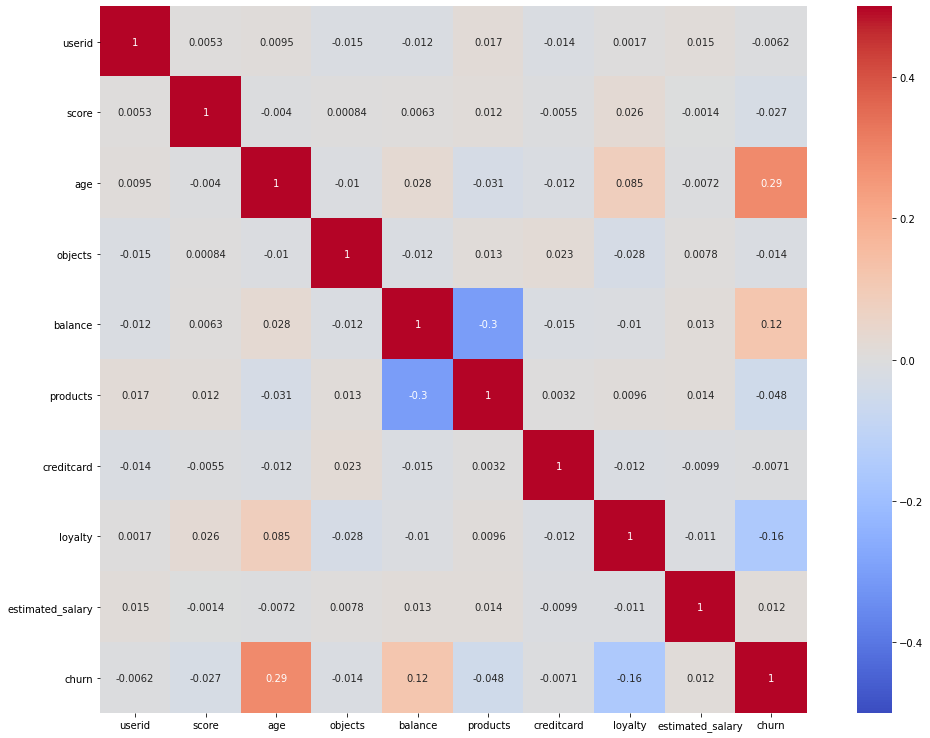

In [78]:
cm = metpr.corr()
plt.figure(figsize = (18, 13))
sns.heatmap(cm, annot = True, square = True, vmin = -0.5, vmax = 0.5, cmap = 'coolwarm')
plt.show()

Наибольшую корреляцию к оттоку имеют:

- age 0.29;
- balance 0.12;
- loyality -0.16.


"Для оценки силы связи в теории корреляции применяется шкала английского статистика Чеддока: слабая — от 0,1 до 0,3; умеренная — от 0,3 до 0,5; заметная — от 0,5 до 0,7; высокая — от 0,7 до 0,9; весьма высокая (сильная) — от 0,9 до 1,0."

Следовательно, показатели, указанные выше по шкале Чеддока считаем слабой корреляцией

## Выводы по разделу

Сформирован примерный портрет пользователя, который вероятнее всего попадет в отток:

В почти равной степени может быть  и мужчина и женщина среднего возраста, с большим количеством продуктов банка( ближе к 4), использует кредитную карту и имеет средний уровень заработной платы. Предположительно проживает в Ростове Великом.

Портрет лояльного ("хорошего") клиента выглядит примерно так:
Чаще это мужчина, в возрасте до 37, в среднем имеющая 2 продукта банка, активно пользуются банковским продуктом - кредитной картой, чем клиент в оттоке и является достаточно активным клиентом банка.

# Проверка гипотез

## Гипотеза № 1


Гипотеза о различии возраста между теми клиентами, которые ушли и теми, которые остались.

Посмотрим на распределение возраста клиентов и посроим точечный график распределения.

Text(0.5, 1.0, 'Распределение возраста клиентов')

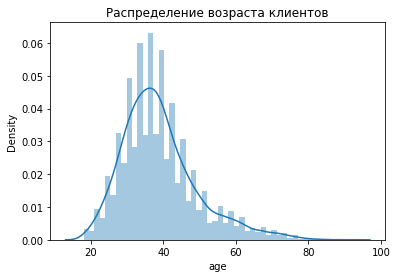

In [79]:
sns_plot = sns.distplot(metpr['age'])
fig = sns_plot.get_figure()
plt.title('Распределение возраста клиентов')

В данном случае распределение больше приближено к нормальному, но есть небольшой перекос в виде нескольких клиентов довольно преклонного возраста.
Делаем вывод, распределение не нормальное, а скошенное/ассиметричное, слева от центра.


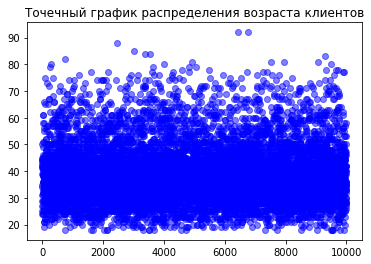

In [80]:
x_values = pd.Series(range(0,len(metpr['age'])))
plt.scatter(x_values, metpr['age'], color='blue', alpha=0.5)
plt.title('Точечный график распределения возраста клиентов')
plt.show()

Распределение не совсем равномерное и имеются клиенты довольно приклонного возраста. В данном случае воспользуемся кретерием Манна-Уитни.

Распределение не нормальное, а скошенное влево. Я все-таки считаю, что здесь необходимо применить критерий Манна-Уитни, так как присутсвует выброс в сторону нескольких клиентов очень приклонного возраста (самый старший 92 года)

Сформулируем гипотезы:

H0: Возраст клиентов ушедших в отток и оставшихся не различается

H1: Возраст клиентов ушедших в отток и оставшихся различается

In [81]:
alpha = 0.05

results = st.mannwhitneyu(metpr[metpr['churn']==1]['age'], metpr[metpr['churn']==0]['age'])
pvalue = results.pvalue

print('p-значение: ', pvalue)

if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

p-значение:  3.2104014319371675e-230
Отвергаем H0: разница статистически значима


In [82]:
# Посмотрим на медианный возраст клиентов
metpr.pivot_table(index='churn', values='age', aggfunc='median')

age
churn     
0       36
1       45

In [83]:
# Посмотрим на средний возраст
metpr.pivot_table(index='churn', values='age', aggfunc='mean')

age
churn      
0     37.41
1     44.84

## Вывод

Не удалось отвергнуть нулевую гипотезу об отсутствии различий в возрасте тех, кто ушел в отток и кто не ушел. И как мы видим, действительно разница в возрасте составляет около 10 лет.

## Гипотеза № 2



Гипотеза о различии дохода между теми клиентами, которые ушли и теми, которые остались

Посмотрим на распределение уровня дохода клиентов и построим точечный график.

Text(0.5, 1.0, 'Распределение уровня дохода клиентов')

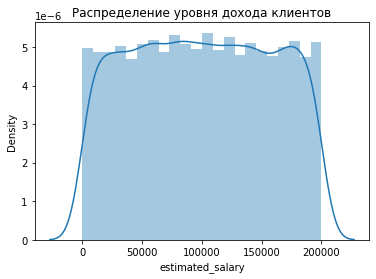

In [84]:
sns_plot = sns.distplot(metpr['estimated_salary'])
fig = sns_plot.get_figure()
plt.title('Распределение уровня дохода клиентов')

По графику рспределения можно сказать, что распределение не идеальное, но приближенное к нормальному.

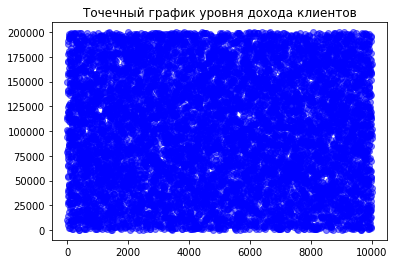

In [85]:
x_values = pd.Series(range(0,len(metpr['estimated_salary'])))
plt.scatter(x_values, metpr['estimated_salary'], color='blue', alpha=0.5)
plt.title('Точечный график уровня дохода клиентов')
plt.show()

Тут так же на наблюдается выбросов в данных. Следовательно, при проверке гипотез мы можем использовать t-тест(распределение Стьюдента) или U-критерий (Манна-Уитни). U критерий - наиболее мощная (чувствительная) непараметрическая альтернатива t-критерия для независимых выборок, в некоторых случаях он имеет даже большую мощность, чем t-критерий, поэтому будем использовать его.

Сформулируем гипотезы:

H0: доход клиентов, которые ушли не превосходит доход, которые остались

H1: доход клиентов, которые ушли превосходит доход, которые остались

In [98]:
sample_A = metpr.query('churn == 0')['estimated_salary']
sample_B = metpr.query('churn == 1')['estimated_salary']

alpha = .05 # уровень статистической значимости

results = st.ttest_1samp(
    sample_A, 
    sample_B)

# тест односторонний: p-value будет в два раза меньше
print('p-значение:', results.pvalue / 2)

# тест односторонний 
if ((results.pvalue / 2 < alpha) & (sample_A.mean() > sample_B.mean())).any():
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя") 

p-значение: 0      0.01
2      0.00
5      0.00
7      0.00
16     0.00
       ... 
9981   0.00
9982   0.00
9991   0.00
9997   0.00
9998   0.00
Name: estimated_salary, Length: 2037, dtype: float64
Не получилось отвергнуть H0: вывод о различии сделать нельзя


In [92]:
print('Среднее значение дохода у тех, кто ушел в отток:', metpr[metpr['churn']==1]['estimated_salary'].mean())
print('Среднее значение дохода у тех, кто не ушел в отток:', metpr[metpr['churn']==0]['estimated_salary'].mean())
print('Медианное значение дохода у тех, кто ушел в отток:', metpr[metpr['churn']==1]['estimated_salary'].median())
print('Медианное значение дохода у тех, кто не ушел в отток:', metpr[metpr['churn']==0]['estimated_salary'].median())

Среднее значение дохода у тех, кто ушел в отток: 101465.67753068237
Среднее значение дохода у тех, кто не ушел в отток: 99738.39177194524
Медианное значение дохода у тех, кто ушел в отток: 102460.84
Медианное значение дохода у тех, кто не ушел в отток: 99645.04


In [94]:
#дополнительно посмотрим на относительную разницу средних
print('{0:.2%}'.format(sample_B.mean() / sample_A.mean() - 1))

1.73%


## Вывод
Доход клиентов, которые ушли в отток немного превосходит доход клиентв, которые остались. Но данная разница не несет в себе большой статистической значимости.

## Вывод по разделу:

В этом пункте мы проверили гипотезы и выяснили, что:

1. Возраст тех, кто ушел в отток и тех, кто остался - различается. В среднем на 10 лет
2. Доход клиентов, которые ушли в отток немного превосходит доход клиентв, которые остались. 

# Общий вывод

На основе предоставленных данных, можно сделать следующие выводы:

- Большое количетсво пропусков может быть обусловлено технической ошибкой, но можно предположить, что не каждый клиент в банке имеет депозитные счета, некоторые пользуются исключительно кредитными продуктами, поэтому у нас есть основание полагать, что пропущенные значения это фактически нули, ведь никакого баланса у этих клиентов нет.
- Выявили проблему в данных, необходимо связаться с человеком, предоставившим данные, либо с технической поддержкой: 

Минимальная заработная плата выглядит слишком низкой. Mинимальная заработная плата в России составляет около 12 тыс.руб., однако, могут быть ситуации (инвалиды, домохозяйки и т.п.) Возможно, человек предоставляет изредка какиой-то вид услуг, варианты могут быть разные. Так же возможен вариант, что данные не были предоставлены и значения были получены при расчетах специальной моделью. Посмотрим на данные в нашей выборке, где зп ниже минимальной по стране.
- Клиенты, которые пользуются 1-2 продуктами банка являются представителями обоих полов в примерно равных долях (с небольшим перевесом в сторону мужчин), в возрасте моложе 40 лет, заработком около 100 тыс. рублей, в половине своей активно используют банковские продукты
- Клиенты из групп с тремя и четырьмя продуктами в большинстве женщины старше 40 лет, с заработной платой чуть выше 100 тыс. рублей, и что характерно, большинство расторгают свои отношения с банком (особенно те, у кого четыре продукта - показатель оттока 100 %).
- мужчины чаще склонны оставаться клиентами банка
- Сформированы примерные портреты пользователей, который вероятнее всего попадет в отток:
В почти равной степени может быть и мужчина и женщина среднего возраста, с большим количеством продуктов банка( ближе к 4), использует кредитную карту и имеет средний уровень заработной платы. Предположительно проживает в Ростове Великом.

Портрет лояльного ("хорошего") клиента выглядит примерно так: Чаще это мужчина, в возрасте до 37, в среднем имеющая 2 продукта банка, активно пользуются банковским продуктом - кредитной картой, чем клиент в оттоке и является достаточно активным клиентом банка.
- Возраст тех, кто ушел в отток и тех, кто остался - различается. В среднем на 10 лет
- Доход клиентов, которые ушли в отток немного превосходит доход клиентв, которые остались. 

# Рекомендации

- для работы с клиентами наиболее склонными к оттоку внутри категорий можно разработать специальные предложения. Пример: для людей пенсионного возраста ввести льготы на продукты и услуги, так как они наиболее склонны к оттоку(в рамках своей категории)
- подготовить маркетинговые акции, которые будут содержать в себе активные действия с какими-либо бонусами для клиентов, что побудит их к естественной активности, а активный клиент, как мы выяснили - наименее склонен к оттоку;